<a href="https://colab.research.google.com/github/imaizumi0302/Project-for-Comparing-Missing-Value-Imputation-Methods/blob/main/create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 本プロジェクトの目的
本プロジェクトでは、欠損値補完方法の違いが
モデルの性能および内部構造にどのような影響を与えるかを検証する。
特に、default を見逃さないこと（recall）を重視し、
ロジスティック回帰・決定木・SVM に対して比較を行った。


# ライブラリをインポート

In [1]:
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import missingno as msno
from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge # MICEの予測モデルとして推奨されるベイジアンリッジを使用

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.model_selection import cross_validate


In [3]:
#  Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データ読み込み

In [4]:
df_original = pd.read_csv('hmeq.csv')

In [5]:
df = df_original.copy()

In [6]:
df.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


In [7]:
df.shape

(5960, 13)

In [8]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [9]:
df["REASON"].value_counts()

,count
REASON,
DebtCon,3928
HomeImp,1780


In [10]:
df["BAD"].value_counts()

,count
BAD,
0,4771
1,1189


In [11]:
df.isnull().sum()

,0
BAD,0
LOAN,0
MORTDUE,518
VALUE,112
REASON,252
JOB,279
YOJ,515
DEROG,708
DELINQ,580
CLAGE,308


In [12]:
# # 数値型列の選択
# # 'REASON'と'JOB'はカテゴリ変数なので除外
# numeric_df = df.select_dtypes(include=np.number)
# #　カテゴリカルカラムのdfも先に作っておく
# categorical_df = df.select_dtypes(exclude=np.number)


# #  相関行列の計算
# correlation_matrix = numeric_df.corr()

# # 4. ヒートマップの表示
# plt.figure(figsize=(10, 8))
# sns.heatmap(
#     correlation_matrix,
#     annot=True,              # 相関係数の値をセルに表示
#     fmt=".2f",               # 表示形式を小数点以下2桁に指定
#     cmap='coolwarm',         # 色のパレット指定
#     linewidths=.5,           # セルの区切り線の太さ
#     cbar=True                # カラーバーを表示
# )
# plt.title('Correlation Matrix Heatmap (Before Imputation)')
# plt.show()

# # 相関行列の値を表示
# print("相関行列:\n", correlation_matrix)

---  可視化による欠損パターンの確認 ---


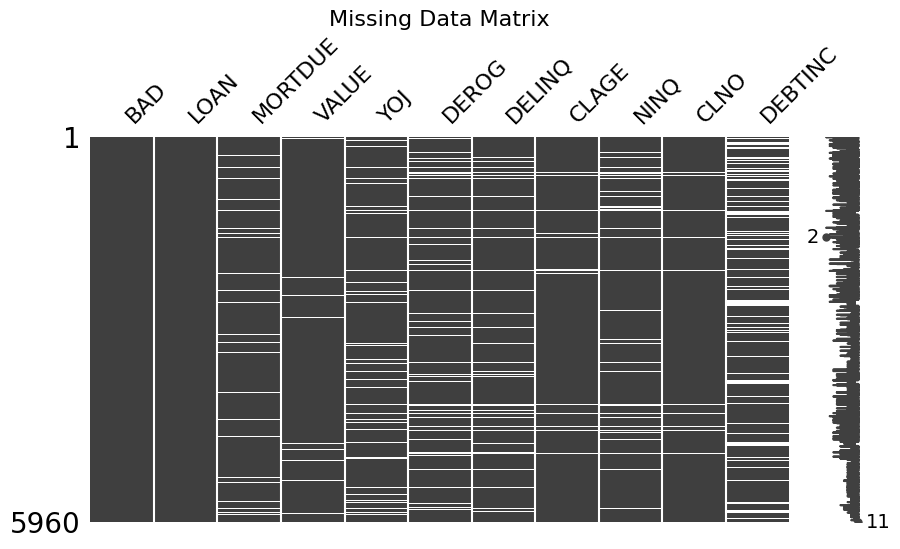

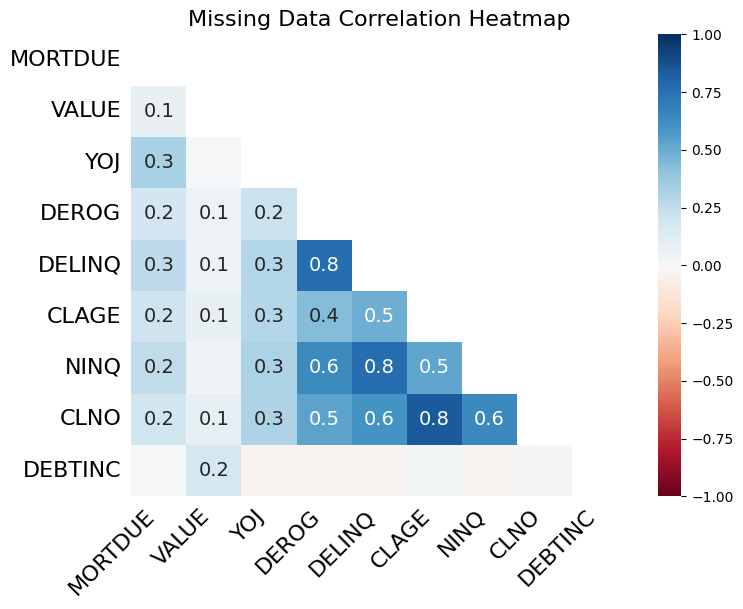

In [13]:
# ----------------------------------------------------
#  可視化による欠損パターンの確認
# ----------------------------------------------------
print("---  可視化による欠損パターンの確認 ---")

numeric_df = df.select_dtypes(include=np.number)

#  Matrix Plot: 欠損パターンを行列として表示
msno.matrix(numeric_df, figsize=(10, 5))
plt.title('Missing Data Matrix', fontsize=16)
plt.show()


#  Heatmap: 欠損状態同士の相関を表示
# 1に近いほど、片方が欠損するともう片方も欠損しやすい
msno.heatmap(numeric_df, figsize=(8, 6))
plt.title('Missing Data Correlation Heatmap', fontsize=16)
plt.show()

In [14]:
#----------------------------------------------------------
# 各カラムごとに他のカラムとの欠損の依存関係をt検定を使用し判定
#----------------------------------------------------------

#  欠損値を持つすべてのカラムを特定
cols_with_missing = numeric_df.columns[numeric_df.isnull().any()].tolist()

print(f"欠損傾向を分析するターゲットカラム: {cols_with_missing}")
print("-" * 50)

#  すべての欠損カラムをターゲットとしてループ
for target_col in cols_with_missing:

    print(f"\n======== ターゲット: {target_col} の欠損傾向分析 ========")

    # ターゲット列が欠損しているかどうかを示すフラグ列を作成
    is_missing_flag = numeric_df[target_col].isnull()

    # 比較対象となる他の列をリストアップ
    # (ターゲット列とフラグ列自身は除外)
    test_cols = [col for col in numeric_df.columns if col != target_col]

    for col in test_cols:

        # 観測群と欠損群の値を抽出
        observed_values = numeric_df[~is_missing_flag][col].dropna()
        missing_group_values = numeric_df[is_missing_flag][col].dropna()

        # 統計量が計算可能な場合のみ実行
        if len(observed_values) > 1 and len(missing_group_values) > 1:

            # 平均値の計算
            mean_observed = observed_values.mean()
            mean_missing = missing_group_values.mean()

            # t検定
            t_stat, p_value = stats.ttest_ind(observed_values, missing_group_values, equal_var=False)

            print(f"\n- 比較対象変数: {col}")
            print(f"  {target_col} 観測群の {col} 平均: {mean_observed:.2f}")
            print(f"  {target_col} 欠損群の {col} 平均: {mean_missing:.2f}")
            print(f"  t検定 P値: {p_value:.4f}")

            if p_value < 0.05:
                print(f"  => 結論: 統計的有意差あり。{target_col} の欠損は {col} の値に依存している可能性（MAR/NMAR）")
            else:
                print(f"  => 結論: 統計的有意差なし。{target_col} の欠損は {col} の値に依存している可能性は低い（MCARの可能性）")

欠損傾向を分析するターゲットカラム: ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
--------------------------------------------------

======== ターゲット: MORTDUE の欠損傾向分析 ========

- 比較対象変数: BAD
  MORTDUE 観測群の BAD 平均: 0.20
  MORTDUE 欠損群の BAD 平均: 0.20
  t検定 P値: 0.7618
  => 結論: 統計的有意差なし。MORTDUE の欠損は BAD の値に依存している可能性は低い（MCARの可能性）

- 比較対象変数: LOAN
  MORTDUE 観測群の LOAN 平均: 18646.36
  MORTDUE 欠損群の LOAN 平均: 18204.63
  t検定 P値: 0.4348
  => 結論: 統計的有意差なし。MORTDUE の欠損は LOAN の値に依存している可能性は低い（MCARの可能性）

- 比較対象変数: VALUE
  MORTDUE 観測群の VALUE 平均: 104998.16
  MORTDUE 欠損群の VALUE 平均: 66621.56
  t検定 P値: 0.0000
  => 結論: 統計的有意差あり。MORTDUE の欠損は VALUE の値に依存している可能性（MAR/NMAR）

- 比較対象変数: YOJ
  MORTDUE 観測群の YOJ 平均: 8.95
  MORTDUE 欠損群の YOJ 平均: 8.52
  t検定 P値: 0.3608
  => 結論: 統計的有意差なし。MORTDUE の欠損は YOJ の値に依存している可能性は低い（MCARの可能性）

- 比較対象変数: DEROG
  MORTDUE 観測群の DEROG 平均: 0.25
  MORTDUE 欠損群の DEROG 平均: 0.37
  t検定 P値: 0.0428
  => 結論: 統計的有意差あり。MORTDUE の欠損は DEROG の値に依存している可能性（MAR/NMAR）

- 比較対象変数: DELINQ
  MORTDUE 観

In [15]:
# 1. 欠損値が多い行の確認 (非欠損値が個未満の行をチェック)
# 12列 - 4列 = 9列以上の欠損
for thresh in range(1,len(df.columns)+1):
  rows_to_drop_count = df.dropna(thresh=thresh).shape[0]

  print(f"非欠損値が {thresh-1} 個以下（欠損値が {12-thresh+1} 個以上）の行数: {len(df) - rows_to_drop_count}行({(len(df) - rows_to_drop_count)*100/len(df):.2f}%)")


非欠損値が 0 個以下（欠損値が 12 個以上）の行数: 0行(0.00%)
非欠損値が 1 個以下（欠損値が 11 個以上）の行数: 0行(0.00%)
非欠損値が 2 個以下（欠損値が 10 個以上）の行数: 2行(0.03%)
非欠損値が 3 個以下（欠損値が 9 個以上）の行数: 13行(0.22%)
非欠損値が 4 個以下（欠損値が 8 個以上）の行数: 62行(1.04%)
非欠損値が 5 個以下（欠損値が 7 個以上）の行数: 101行(1.69%)
非欠損値が 6 個以下（欠損値が 6 個以上）の行数: 126行(2.11%)
非欠損値が 7 個以下（欠損値が 5 個以上）の行数: 192行(3.22%)
非欠損値が 8 個以下（欠損値が 4 個以上）の行数: 275行(4.61%)
非欠損値が 9 個以下（欠損値が 3 個以上）の行数: 339行(5.69%)
非欠損値が 10 個以下（欠損値が 2 個以上）の行数: 558行(9.36%)
非欠損値が 11 個以下（欠損値が 1 個以上）の行数: 1007行(16.90%)
非欠損値が 12 個以下（欠損値が 0 個以上）の行数: 2596行(43.56%)


# 欠損値処理


In [16]:
# ドロップの実行
# 全説明変数のうち、半分以上欠損している行をdropする
threshold = 7

df_filtered = df.dropna(thresh=threshold)

print(f"ドロップ後の行数: {len(df_filtered)}")

ドロップ後の行数: 5834


# 数値型カラムとカテゴリ型カラムに分割
- miceで補完時に、数値型のみのデータを作り、miceを適用していくため
- 補完後に、再度結合する

In [17]:
# 数値型列の選択
# 'REASON'と'JOB'はカテゴリ変数なので除外
numeric_df_filtered = df_filtered.select_dtypes(include=np.number)


## 数値型の欠損値補完

### 平均値 or 0 で補完


In [18]:
def impute_mean(data):
  data = data.copy()

  ## 欠損値の補完

  # 数値変数（平均値または 0 で補完）

  # 平均値で補完する列
  # LOAN, MORTDUE, VALUE, CLAGE, CLNO, DEBTINC が含まれる
  # これらの値は0をとることは現実的ではない
  mean_impute_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO','DEBTINC']

  # 各列の平均値を計算（NaNを除く）
  means = data[mean_impute_cols].mean()

  for col in mean_impute_cols:
      # 欠損値を平均値で補完する
      data[col] = data[col].fillna(means[col])


  # 0 で補完する列
  # YOJ, DEROG, DELINQ, NINQ は、欠損フラグ作成後に 0 で補完される
  zero_impute_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']

  for col in zero_impute_cols:
      # 欠損値を 0 で補完する
      data[col] = data[col].fillna(0)

  # 補完後の欠損値のカウントを確認
  print("--- 補完後の各列の欠損値カウント ---")
  print(data.isnull().sum())

  return data

### 中央値 or 0 で補完

In [19]:
def impute_median(data):
  data = data.copy()

  ## ---  欠損値の補完 ---

  # 数値変数（中央値または 0 で補完）

  # 中央値で補完する列
  # LOAN, MORTDUE, VALUE, CLAGE, CLNO, DEBTINC が含まれる
  # これらの値は0をとることは現実的ではない
  median_impute_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO','DEBTINC']

  # 各列の中央値を計算（NaNを除く）
  medians = data[median_impute_cols].median()

  for col in median_impute_cols:
      # 欠損値を中央値で補完する
      data[col] = data[col].fillna(medians[col])


  # 0 で補完する列
  # YOJ, DEROG, DELINQ, NINQ は、欠損フラグ作成後に 0 で補完される
  zero_impute_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']

  for col in zero_impute_cols:
      # 欠損値を 0 で補完する
      data[col] = data[col].fillna(0)

  # 補完後の欠損値のカウントを確認
  print("--- 補完後の各列の欠損値カウント ---")
  print(data.isnull().sum())

  return data

### 中央値 or 0 で補完+ 欠損フラグ


In [20]:
def impute_median_with_flag(data):
  data = data.copy()

  ## ---  欠損フラグの作成 ---
  # 欠損フラグが必要な列: YOJ, DEROG, DELINQ, CLAGE, NINQ, CLNO, DEBTINC
  # これらは負債比率などネガティブな情報であり、意図的に記入者が記入しなかった可能性があるため、
  # 欠損フラグを立てる
  flag_cols = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

  for col in flag_cols:
      # 欠損フラグ列を作成: 欠損（null）の場合 1、それ以外の場合 0
      data[f'{col}_MISSING'] = data[col].isnull().astype(int)

  ## ---  欠損値の補完 ---

  # 数値変数（中央値または 0 で補完）

  # 中央値で補完する列
  # LOAN, MORTDUE, VALUE, CLAGE, CLNO, DEBTINC が含まれる
  # これらの値は0をとることは現実的ではない
  median_impute_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO','DEBTINC']

  # 各列の中央値を計算（NaNを除く）
  medians = data[median_impute_cols].median()

  for col in median_impute_cols:
      # 欠損値を中央値で補完する
      data[col] = data[col].fillna(medians[col])


  # 0 で補完する列
  # YOJ, DEROG, DELINQ, NINQ は、欠損フラグ作成後に 0 で補完される
  zero_impute_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']

  for col in zero_impute_cols:
      # 欠損値を 0 で補完する
      data[col] = data[col].fillna(0)

  # 補完後の欠損値のカウントを確認
  print("--- 補完後の各列の欠損値カウント ---")
  print(data.isnull().sum())

  return data

### MICE

In [21]:

def impute_mice(data):
  data = data.copy()


  # MICE (IterativeImputer) の設定
  # predictor_type='bayes'（デフォルトはBayesianRidge）が推奨されます
  imputer = IterativeImputer(
      estimator=BayesianRidge(),
      max_iter=20,      # 反復回数 (デフォルト10)
      random_state=42   # 再現性のためのシード値
  )

  # 補完の実行
  # IterativeImputerはNumPy配列として結果を返すため、カラム名やインデックスは別途保持
  imputed_data_array = imputer.fit_transform(data)

  # 補完済みデータをPandas DataFrameに戻す
  data_imputed = pd.DataFrame(
      imputed_data_array,
      columns=data.columns,
      index=data.index
  )

  # 6. 結果の確認
  print("MICE補完後の欠損値の合計:")
  print(data_imputed.isnull().sum().sum())

  return data_imputed

In [22]:
# 各関数を適用
numeric_df_mean = impute_mean(numeric_df_filtered)
numeric_df_median = impute_median(numeric_df_filtered)
numeric_df_median_with_flag = impute_median_with_flag(numeric_df_filtered)
numeric_df_mice = impute_mice(numeric_df_filtered)


--- 補完後の各列の欠損値カウント ---
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64
--- 補完後の各列の欠損値カウント ---
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64
--- 補完後の各列の欠損値カウント ---
BAD                0
LOAN               0
MORTDUE            0
VALUE              0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
YOJ_MISSING        0
DEROG_MISSING      0
DELINQ_MISSING     0
CLAGE_MISSING      0
NINQ_MISSING       0
CLNO_MISSING       0
DEBTINC_MISSING    0
dtype: int64
MICE補完後の欠損値の合計:
0


In [23]:
assert not any(col.endswith('_MISSING') for col in numeric_df_mice.columns)


In [24]:
  # ----------------------------------------------------
  #  補完値と観測値の分布比較 (ヒストグラム)
  # ----------------------------------------------------

def plot_hist(data,data_imputed):
    # 欠損値を持っていたカラムのリストを作成
    cols_with_missing = data.columns[data.isnull().any()].tolist()

    # グラフ描画の設定
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(
        nrows=len(cols_with_missing) // 2 + len(cols_with_missing) % 2,
        ncols=2,
        figsize=(16, 4 * (len(cols_with_missing) // 2 + len(cols_with_missing) % 2))
    )
    axes = axes.flatten() # 2次元配列を1次元に

    # 各欠損値カラムについてヒストグラムを比較
    for i, col in enumerate(cols_with_missing):

        # 元のデータで観測された値
        observed_values = data[col].dropna()

        # MICEによって補完された値
        # 元データでNaNだった行の、補完後のデータフレームの値を取得
        imputed_values = data_imputed.loc[data[col].isnull(), col]

        ax = axes[i]

        # 観測値の分布
        sns.histplot(observed_values, kde=True, color='blue', label='Observed (観測値)', ax=ax, stat='density', alpha=0.6)

        # 補完値の分布
        if len(imputed_values) > 0:
            sns.histplot(imputed_values, kde=True, color='red', label='Imputed (補完値)', ax=ax, stat='density', alpha=0.6)

        ax.set_title(f'Distribution Comparison: {col}', fontsize=12)
        ax.legend(loc='upper right')

    # 使わないサブプロットを非表示にする
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 35251 (\N{CJK UNIFIED IDEOGRAPH-89B3}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 35036 (\N{CJK UNIFIED IDEOGRAPH-88DC}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 23436 (\N{CJK UNIFIED IDEOGRAPH-5B8C}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35251 (\N{CJK UNIFIED IDEOGRAPH-89B3}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pytho

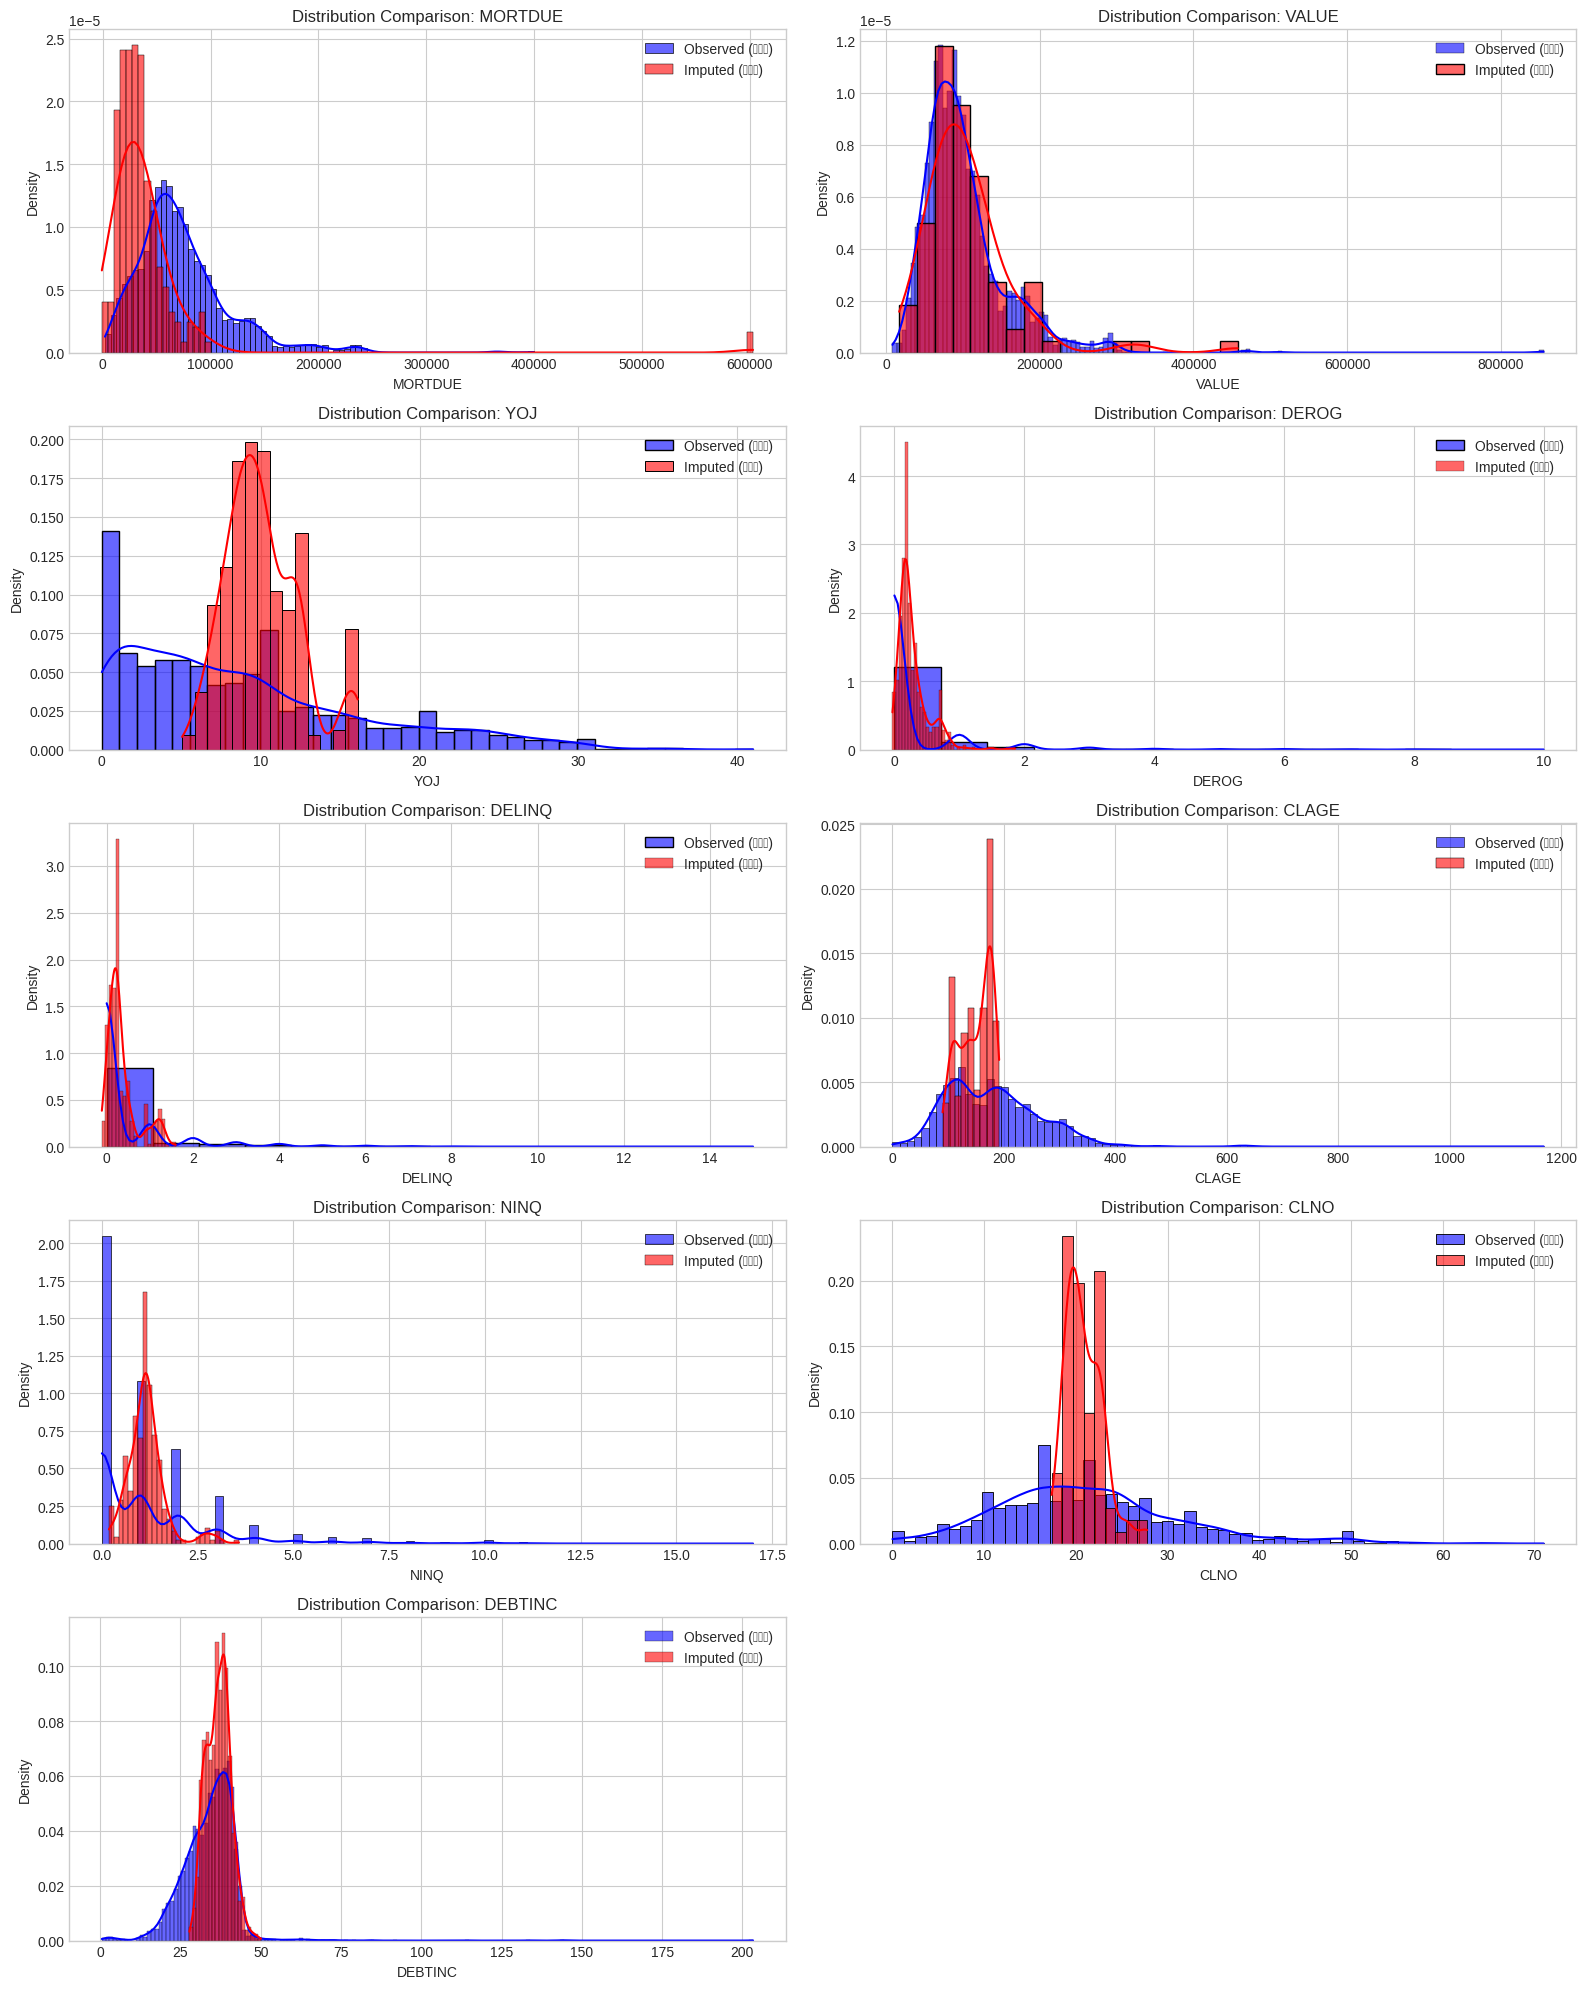

In [25]:
plot_hist(numeric_df_filtered,numeric_df_mice)

/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 35251 (\N{CJK UNIFIED IDEOGRAPH-89B3}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 35036 (\N{CJK UNIFIED IDEOGRAPH-88DC}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3509490373.py:44: UserWarning: Glyph 23436 (\N{CJK UNIFIED IDEOGRAPH-5B8C}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35251 (\N{CJK UNIFIED IDEOGRAPH-89B3}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pytho

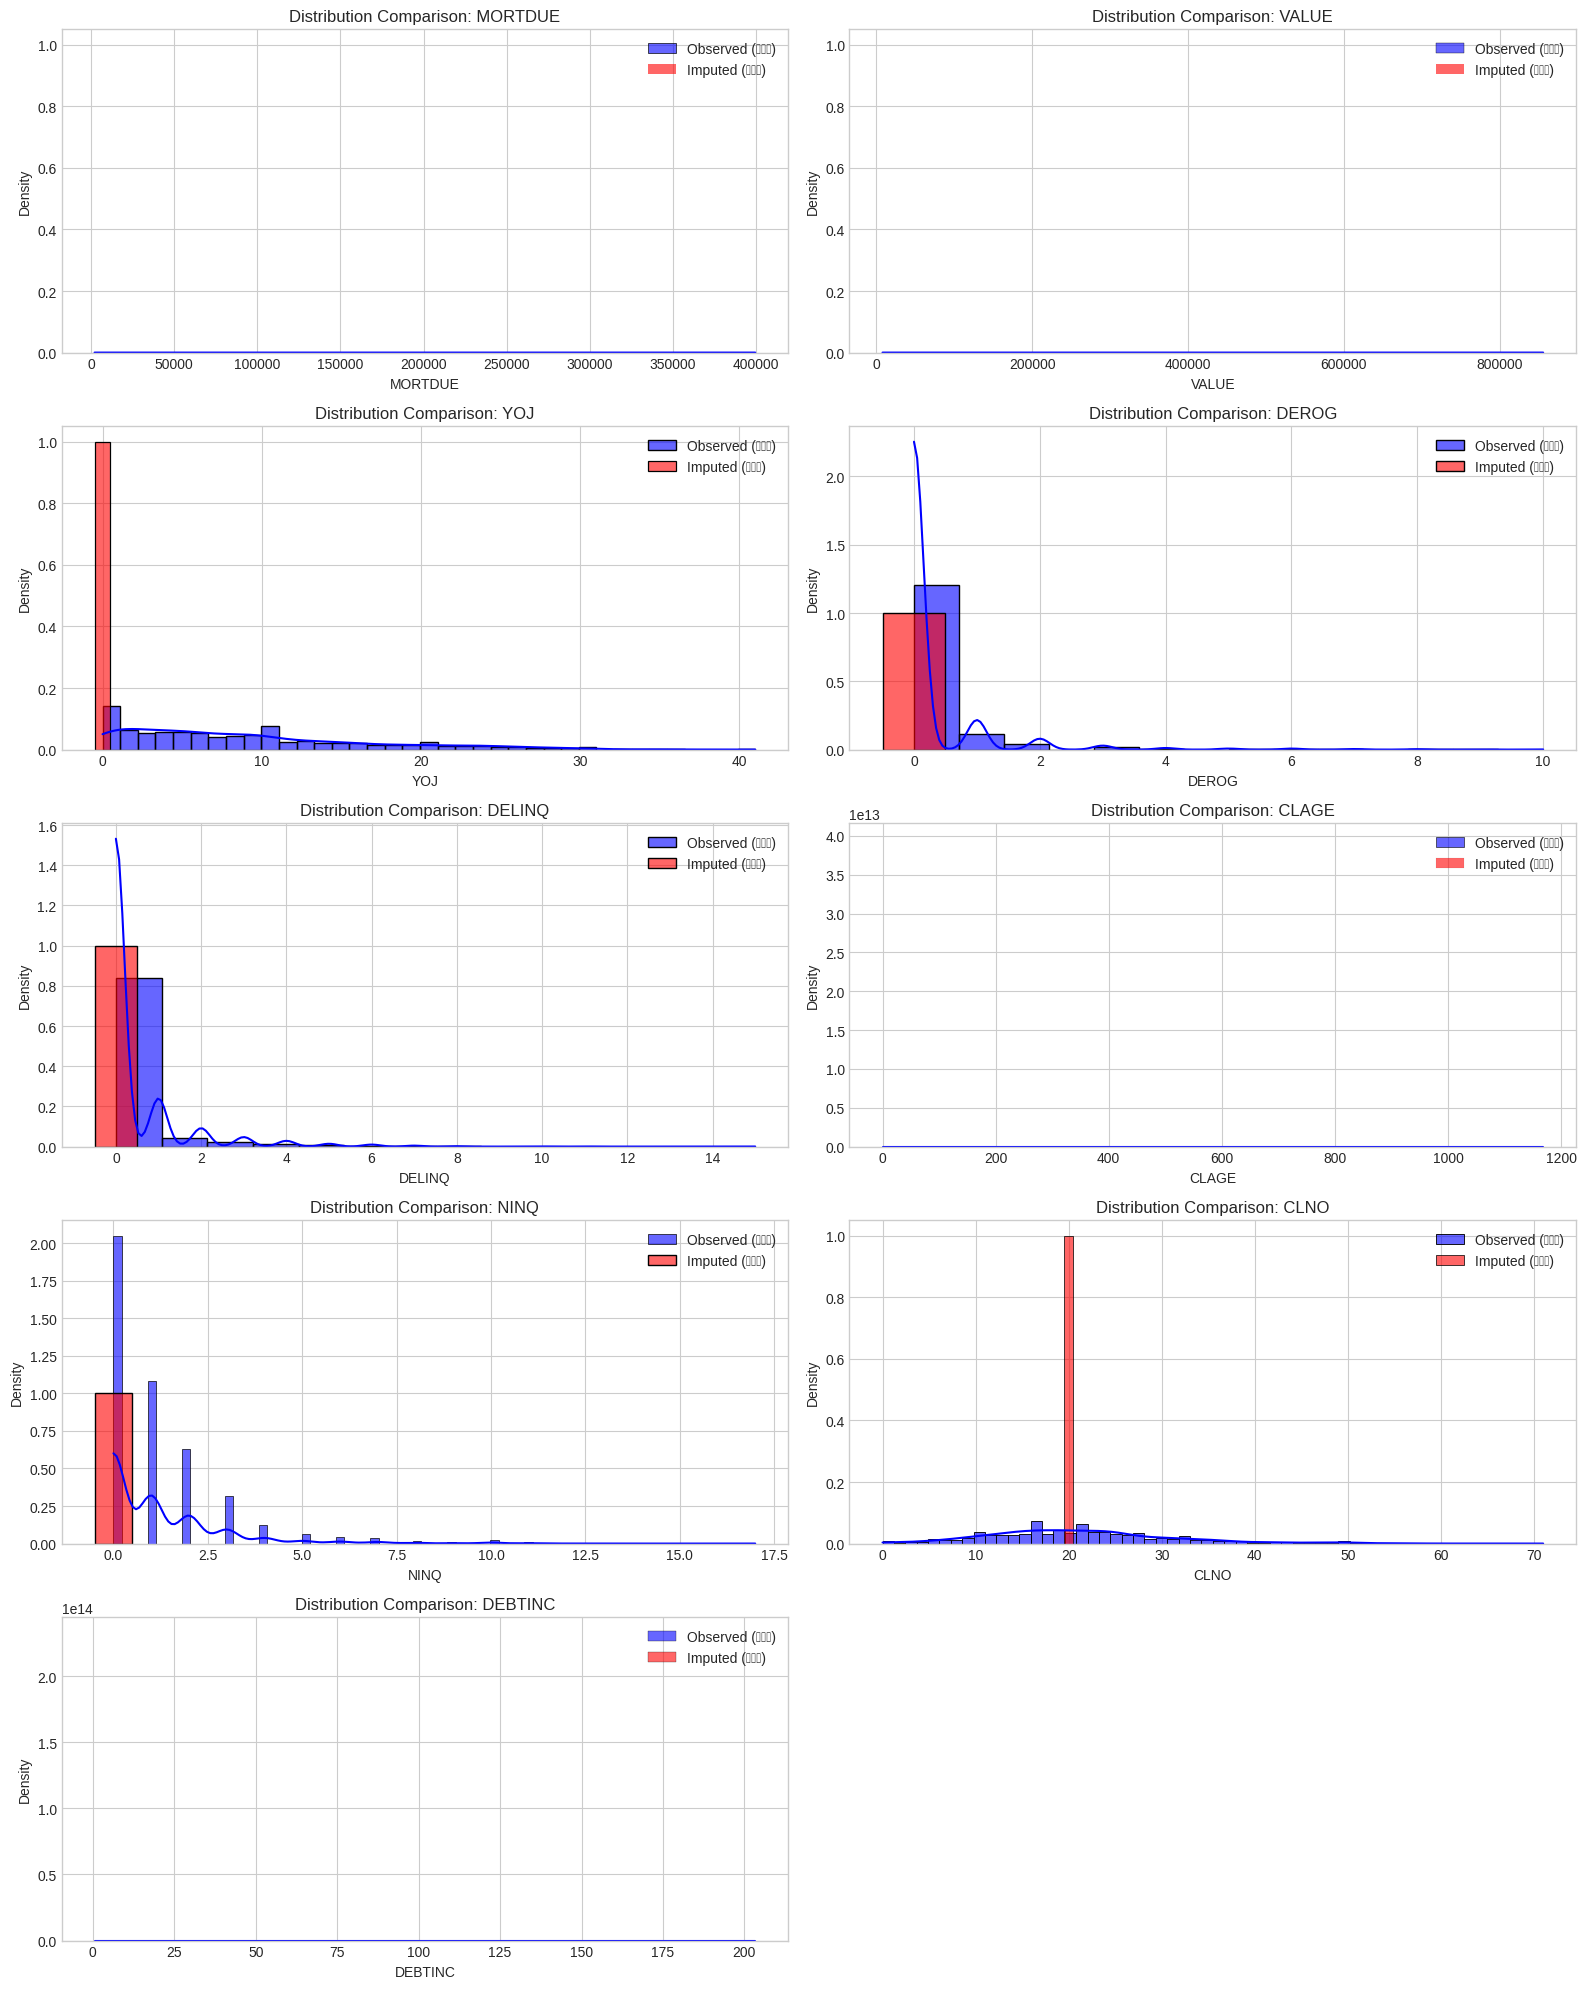

In [26]:
plot_hist(numeric_df_filtered,numeric_df_median)

In [27]:
# # 箱ひげ図を表示
# num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
#        'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
# fig, axes = plt.subplots(2, 5, figsize=(16, 8))
# axes_flat = axes.flatten()
# for i, ax in enumerate(axes_flat):
#     sns.boxplot(data=df_nonmice[num_cols[i]], ax=ax)
#     ax.set_title(num_cols[i])
# plt.tight_layout()
# plt.show()

In [28]:
# # ヒストグラムを表示
# num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
#        'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
# fig, axes = plt.subplots(2, 5, figsize=(16, 8))
# axes_flat = axes.flatten()
# for i, ax in enumerate(axes_flat):
#     sns.histplot(data=df_nonmice[num_cols[i]], ax=ax)
#     ax.set_title(num_cols[i])
# plt.tight_layout()
# plt.show()

CLAGE

異常に大きい値が出やすい

log だけでは抑えきれない

→ キャッピングが必要

他の数値変数

歪度はあるが意味のある大きさ

→ log 変換のみで十分

## カテゴリ型の欠損値補完

In [29]:
# カテゴリカル列を抽出
categorical_df_filtered = df_filtered.select_dtypes(exclude=np.number)


# 欠損値の数を確認
print(f"カテゴリカル変数補完前の欠損数:\n{categorical_df_filtered.isnull().sum()}")
print("-" * 30)

カテゴリカル変数補完前の欠損数:
REASON    167
JOB       174
dtype: int64
------------------------------


In [30]:
# -------------------------------------------------------------------
#  カテゴリカル変数の補完＆numerical変数との結合関数
# -------------------------------------------------------------------
def impute_categorical_features(categorical_data,numeric_data_imputed):
  # 「Missing」カテゴリによる補完
  # NaN値を文字列 'Missing' で埋める
  categorical_data_imputed = categorical_data.fillna('Missing')

  # 欠損値の再確認
  print(f"カテゴリカル変数補完後の欠損数:\n{categorical_data_imputed.isnull().sum()}")
  print("-" * 30)

  # 最終的な統合データフレームの作成
  final_df = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

  return final_df



In [31]:
df_mean = impute_categorical_features(categorical_df_filtered,numeric_df_mean)
df_median = impute_categorical_features(categorical_df_filtered,numeric_df_median)
df_median_with_flag = impute_categorical_features(categorical_df_filtered,numeric_df_median_with_flag)
df_mice = impute_categorical_features(categorical_df_filtered,numeric_df_mice)

カテゴリカル変数補完後の欠損数:
REASON    0
JOB       0
dtype: int64
------------------------------
カテゴリカル変数補完後の欠損数:
REASON    0
JOB       0
dtype: int64
------------------------------
カテゴリカル変数補完後の欠損数:
REASON    0
JOB       0
dtype: int64
------------------------------
カテゴリカル変数補完後の欠損数:
REASON    0
JOB       0
dtype: int64
------------------------------


In [32]:
def display_data(data,name):
  print(f"{name}の先頭5行（欠損値なし）:")
  display(data.head())
  print(f"\n最終的なデータ形状: {data.shape}")
  print(f"最終的なデータフレーム全体の欠損値の合計: {data.isnull().sum().sum()}個")

In [33]:
display_data(df_mean,'df_mean')


df_meanの先頭5行（欠損値なし）:


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,33.896005,HomeImp,Other
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,33.896005,HomeImp,Other
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,33.896005,HomeImp,Other
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,33.896005,HomeImp,Office
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,HomeImp,Other



最終的なデータ形状: (5834, 13)
最終的なデータフレーム全体の欠損値の合計: 0個


In [34]:
display_data(df_median,'df_median')

df_medianの先頭5行（欠損値なし）:


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.888239,HomeImp,Other
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.888239,HomeImp,Other
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.888239,HomeImp,Other
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.888239,HomeImp,Office
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,HomeImp,Other



最終的なデータ形状: (5834, 13)
最終的なデータフレーム全体の欠損値の合計: 0個


In [35]:
display_data(df_median_with_flag,'df_median_with_flag')

df_median_with_flagの先頭5行（欠損値なし）:


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,YOJ_MISSING,DEROG_MISSING,DELINQ_MISSING,CLAGE_MISSING,NINQ_MISSING,CLNO_MISSING,DEBTINC_MISSING,REASON,JOB
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,34.888239,0,0,0,0,0,0,1,HomeImp,Other
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,34.888239,0,0,0,0,0,0,1,HomeImp,Other
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,34.888239,0,0,0,0,0,0,1,HomeImp,Other
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,34.888239,0,0,0,0,0,0,1,HomeImp,Office
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,0,0,0,0,0,0,0,HomeImp,Other



最終的なデータ形状: (5834, 20)
最終的なデータフレーム全体の欠損値の合計: 0個


In [36]:
display_data(df_mice,"df_mice")

df_miceの先頭5行（欠損値なし）:


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1.0,1100.0,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,36.410716,HomeImp,Other
1,1.0,1300.0,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,37.622745,HomeImp,Other
2,1.0,1500.0,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,36.448194,HomeImp,Other
4,0.0,1700.0,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,32.703375,HomeImp,Office
5,1.0,1700.0,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,HomeImp,Other



最終的なデータ形状: (5834, 13)
最終的なデータフレーム全体の欠損値の合計: 0個


# 外れ値処理

In [37]:
# Display box plots
def display_boxhplot_histplot(data):
  num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG',
        'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
  fig1, axes1 = plt.subplots(2, 5, figsize=(16, 8))
  axes_flat1 = axes1.flatten()
  for i, ax in enumerate(axes_flat1):
      sns.boxplot(data=data[num_cols[i]], ax=ax)
      ax.set_title(num_cols[i])
  plt.tight_layout()
  plt.show()

  fig2, axes2 = plt.subplots(2, 5, figsize=(16, 8))
  axes_flat2 = axes2.flatten()
  for i, ax in enumerate(axes_flat2):
    sns.histplot(data=data[num_cols[i]], ax=ax)
    ax.set_title(num_cols[i])
  plt.tight_layout()
  plt.show()

------------------------------
平均値補完をしたデータの分布
------------------------------


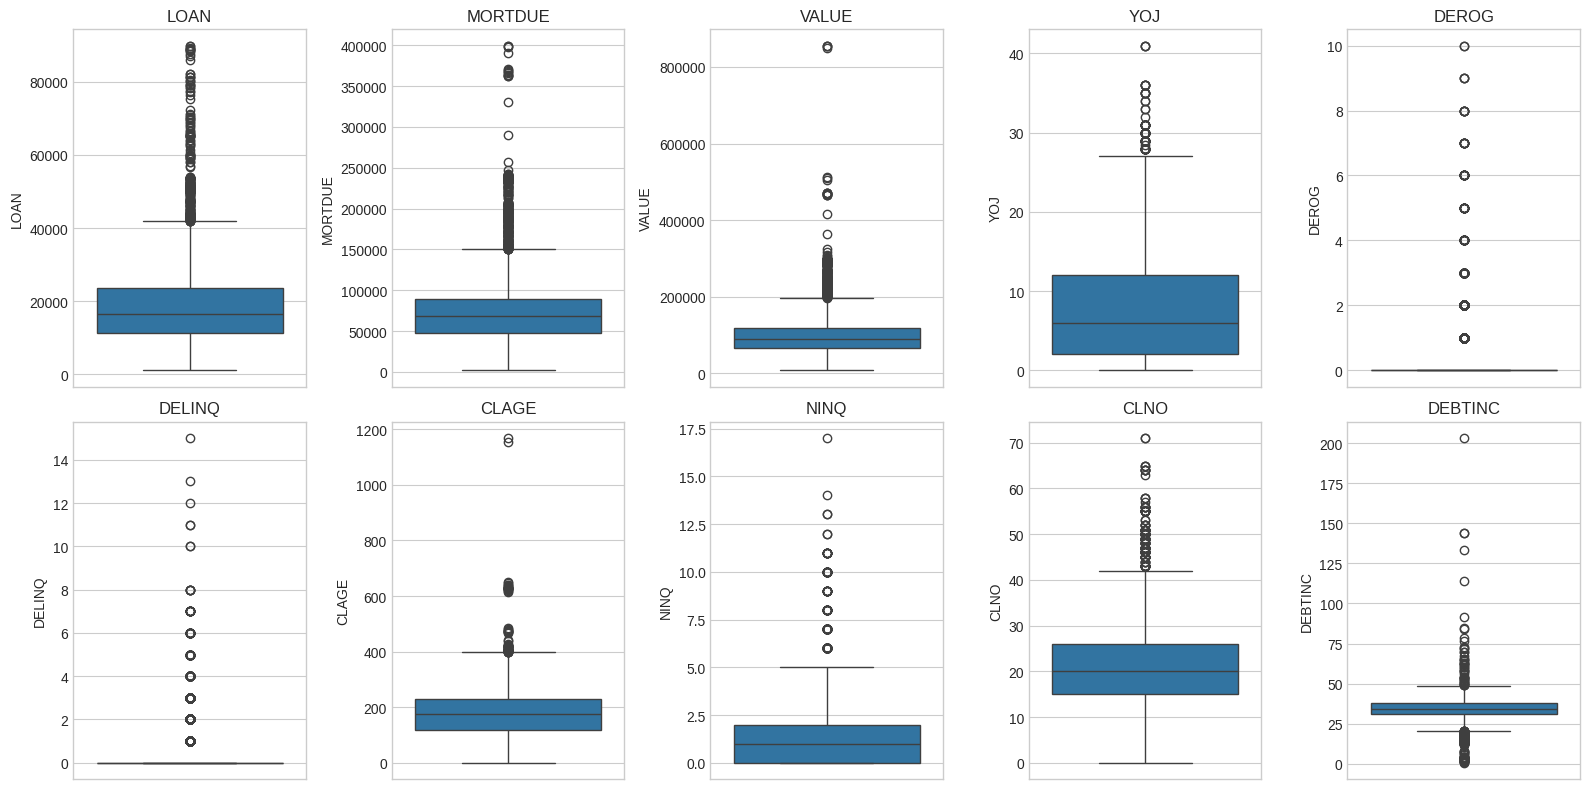

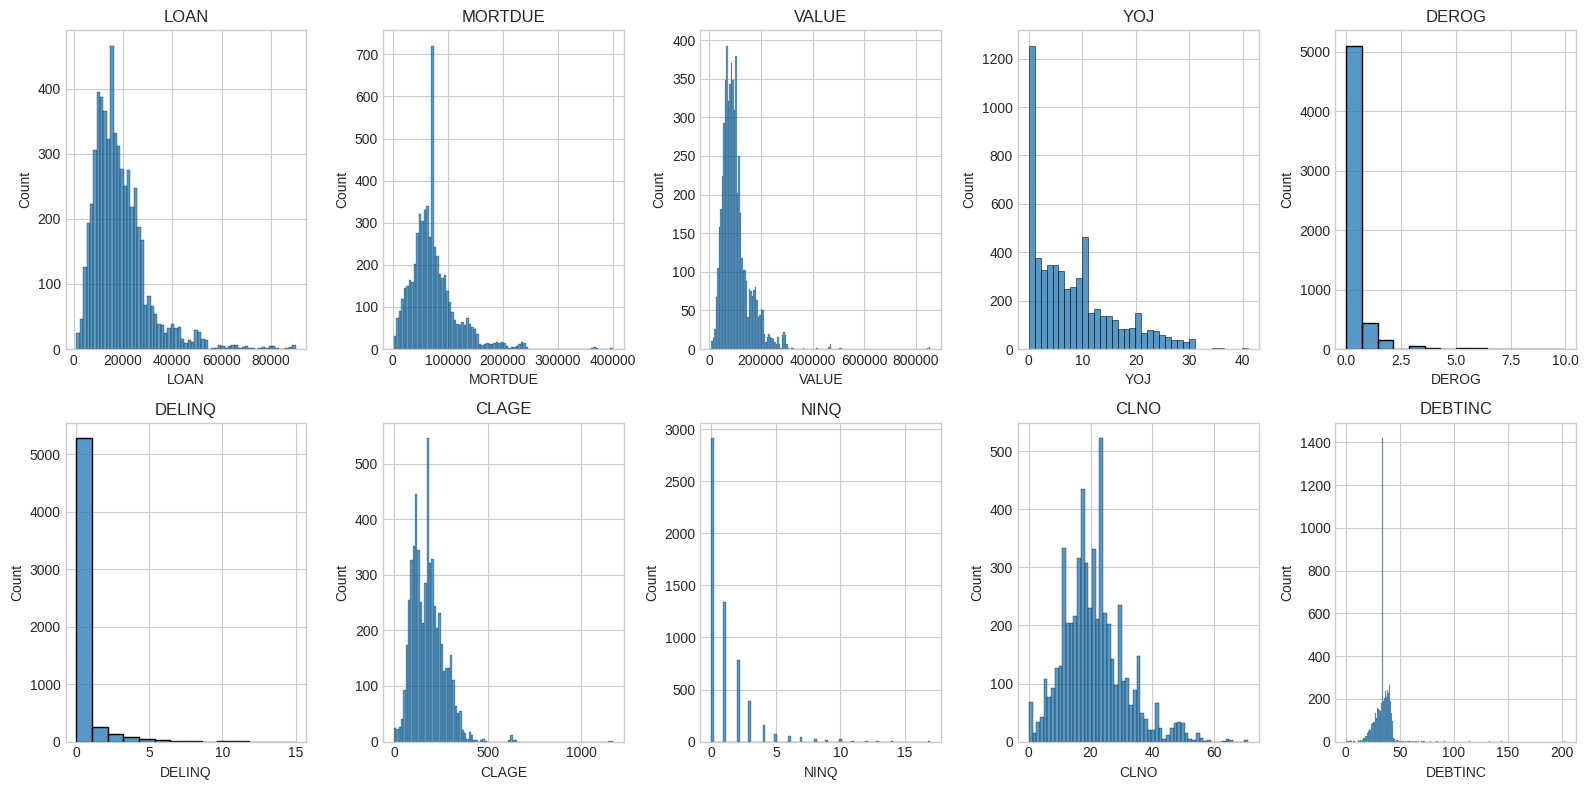

In [38]:
print("-"*30)
print("平均値補完をしたデータの分布")
print("-"*30)

display_boxhplot_histplot(df_mean)

------------------------------
中央値補完をしたデータの分布
------------------------------


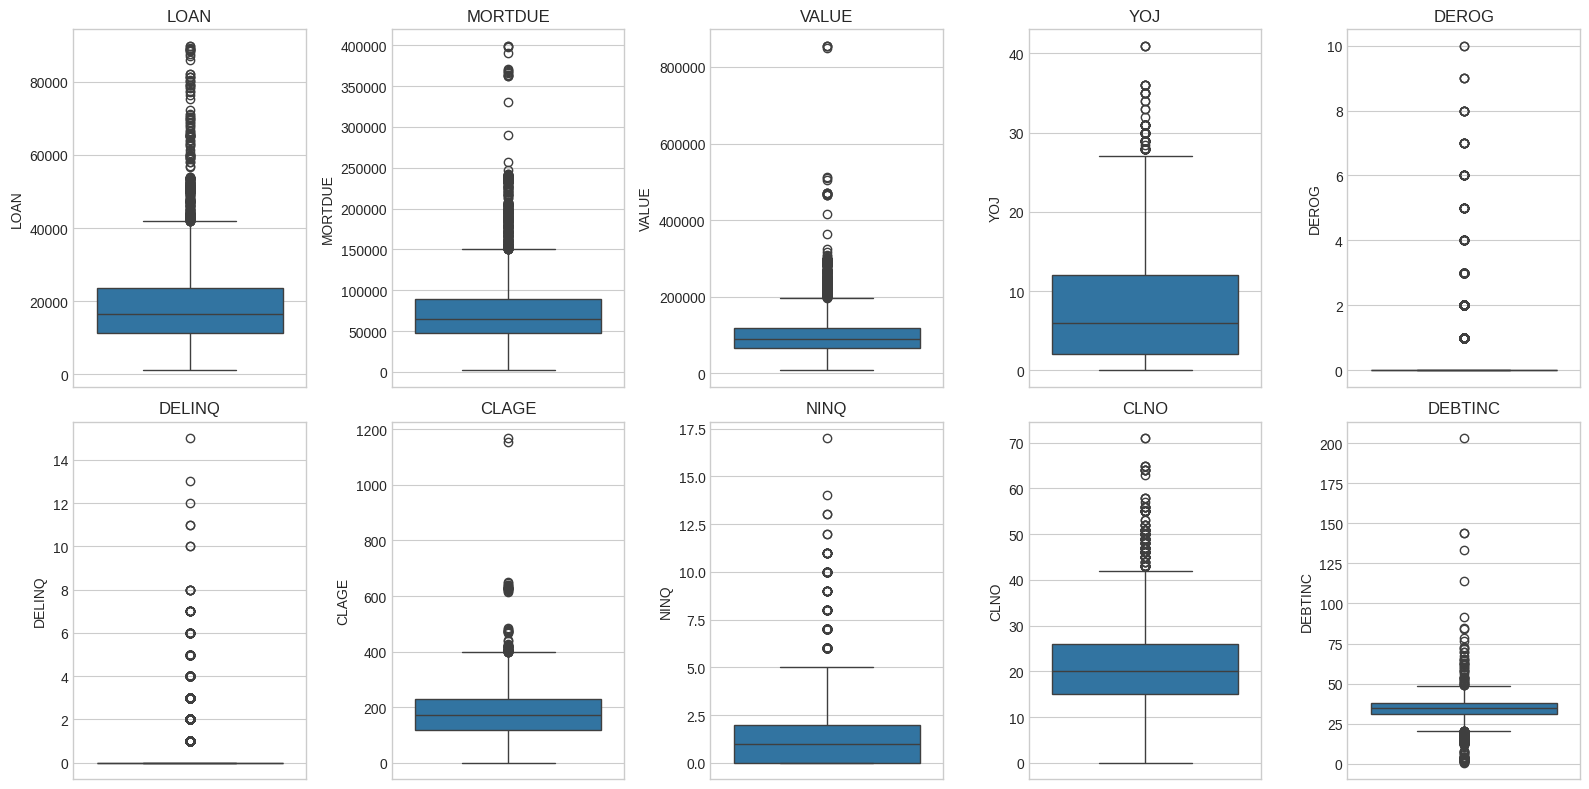

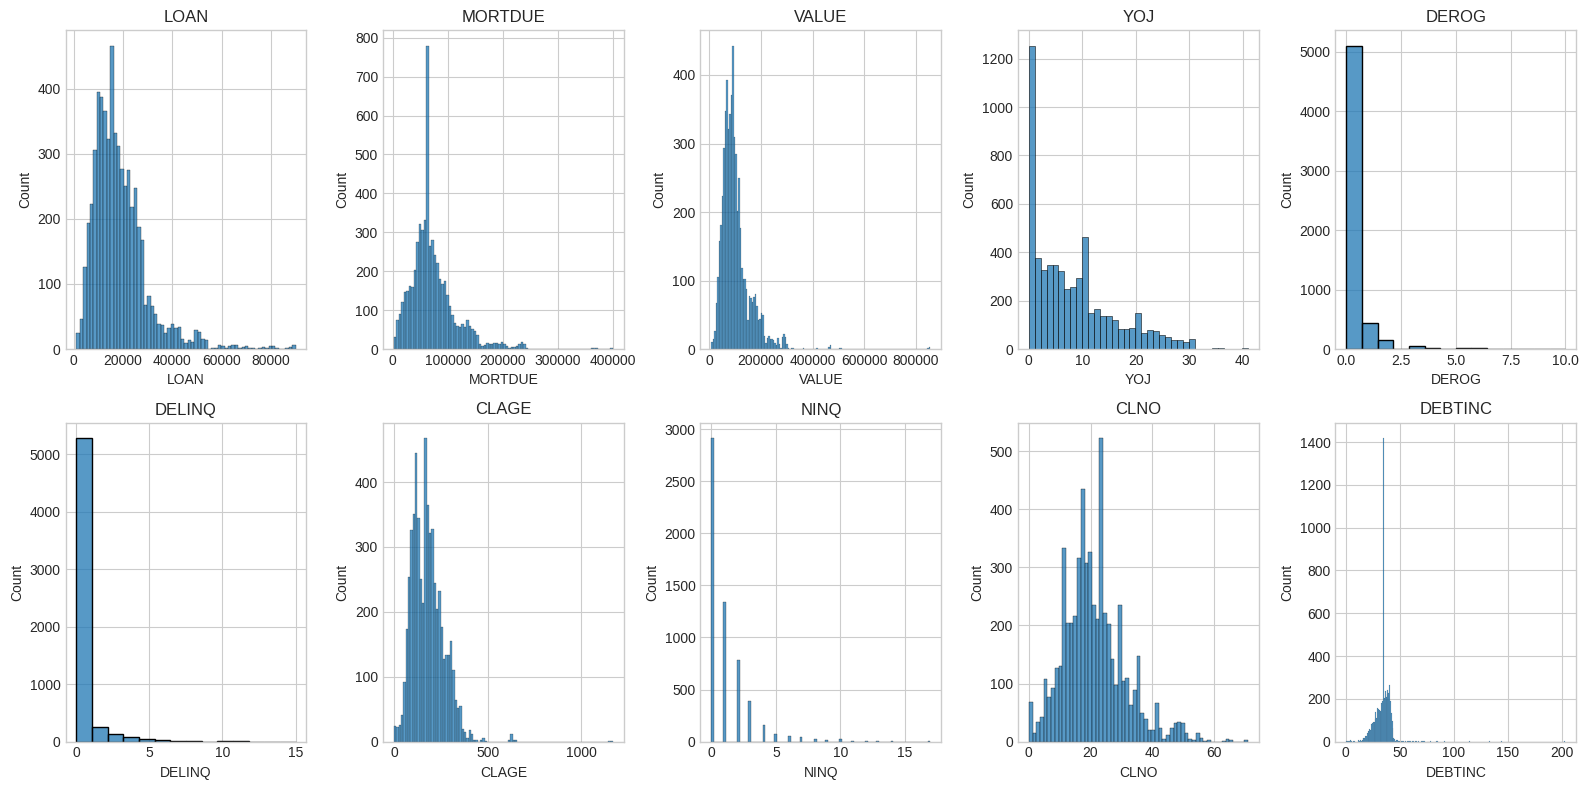

In [39]:
print("-"*30)
print("中央値補完をしたデータの分布")
print("-"*30)
display_boxhplot_histplot(df_median)

------------------------------
mice補完をしたデータの分布
------------------------------


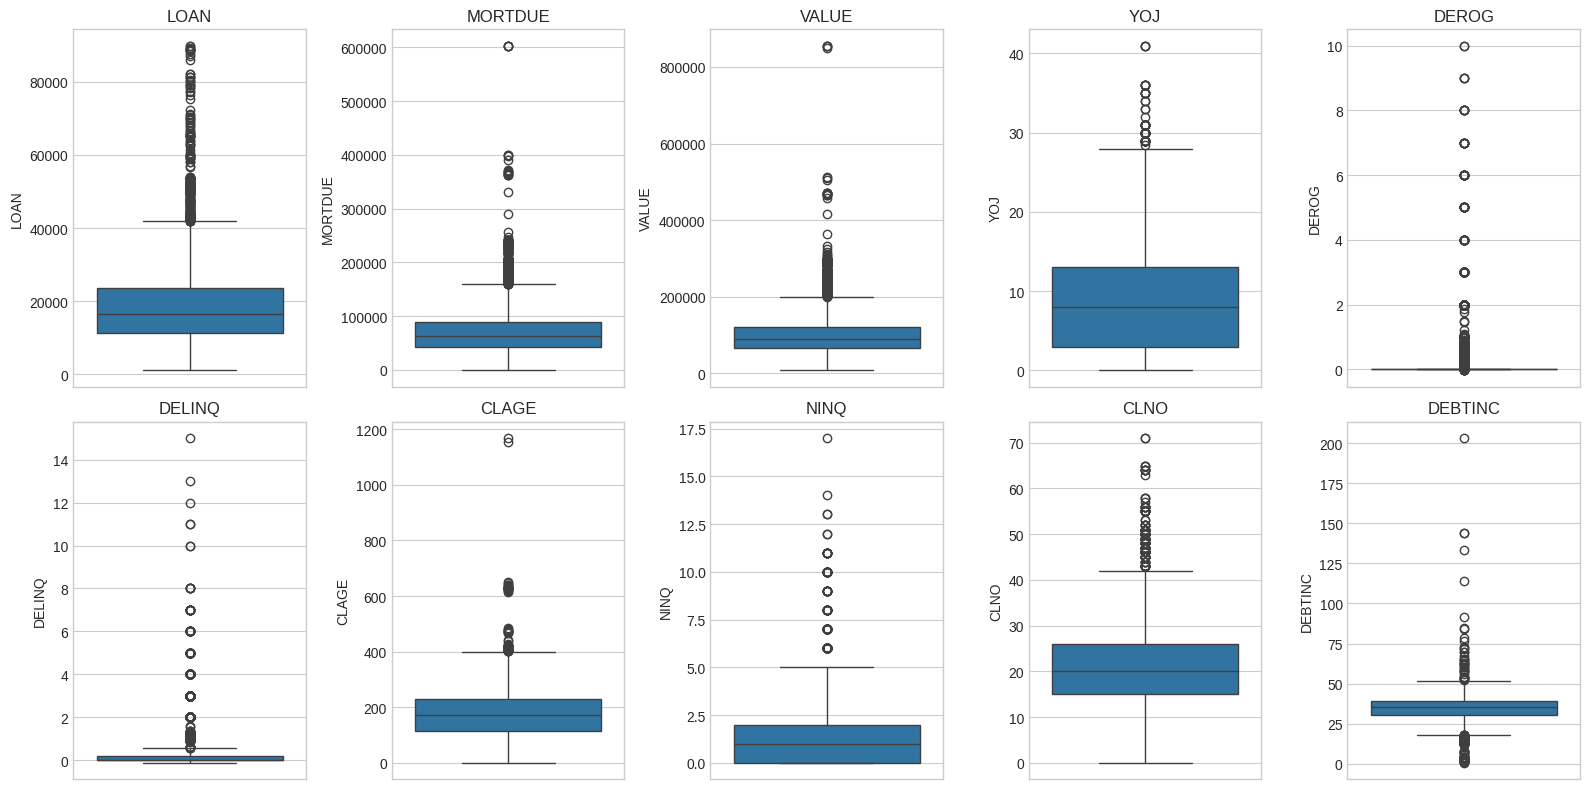

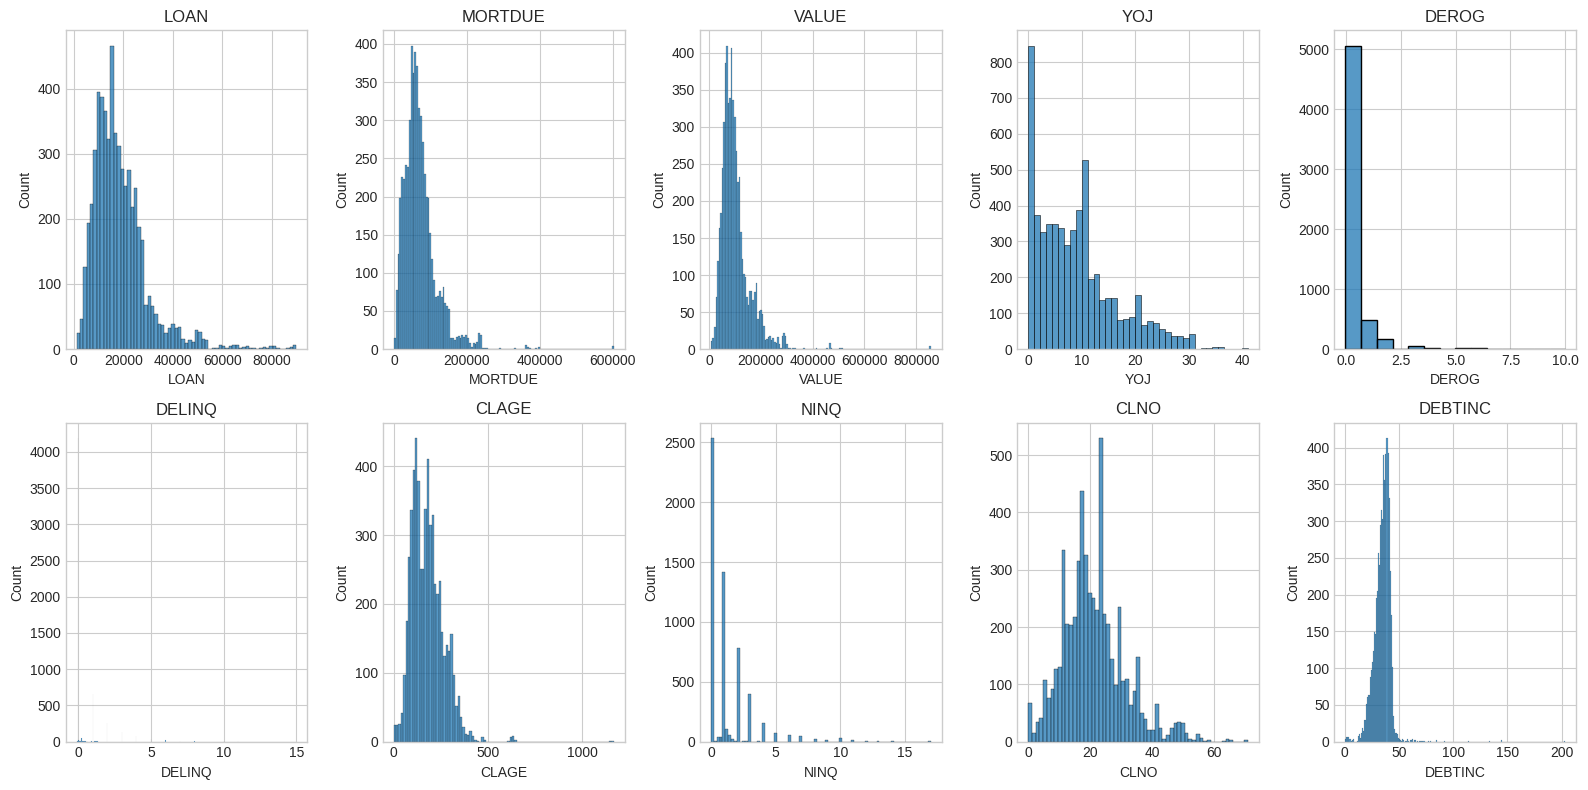

In [40]:
print("-"*30)
print("mice補完をしたデータの分布")
print("-"*30)
display_boxhplot_histplot(df_mice)

## ロジスティック回帰用外れ値処理関数

In [41]:
# DEROG、DELINQ、NINQはそのまま残す

def handle_outliers_lr(data):
  data = data.copy()

  # キャップ処理
  upper_limit_clage = data['CLAGE'].quantile(0.99)
  data['CLAGE'] = data['CLAGE'].clip(upper=upper_limit_clage)

  # 対数変換
  cols_log = ['YOJ', 'CLNO', 'LOAN', 'MORTDUE', 'VALUE', 'DEBTINC']
  for col in cols_log:
        data[col] = np.log1p(data[col].clip(lower=0))

  return data

## SVM用外れ値処理関数

In [42]:
def handle_outliers_svm(data):
  data = data.copy()

  # 金額系：99% キャップ + log
  for col in ['LOAN','MORTDUE','VALUE']:
      upper = data[col].quantile(0.99)
      data[col] = np.log1p(data[col].clip(upper=upper,lower=0))

  # CLAGEは長いことは問題ないが、400か月などは長すぎるので、99%でキャップ処理だけする
  upper = data['CLAGE'].quantile(0.99)
  data['CLAGE'] = data['CLAGE'].clip(upper=upper)

  #------------------------------回数データ：情報を保ったままキャップ----------------------------------------------------------------------------------

  # svmのため、極端な外れ値はノイズになるので、キャップ処理。ただ、この値は顧客のリスクの判断のための重要な情報のため、ある程度は情報を残したい。
  # 分布をみると、ほとんどの人は0であり、数回あるだけでも大きなリスク、逆に、5回の遅延と10回の遅延はどちらもただおなじように高リスクとしてとらえればいいと考える。
  # したがって、5回でキャップをする。
  data['DELINQ'] = data['DELINQ'].clip(upper=5)

  # 重大事故の回数のため、1回でも大きなリスク。大きい値は、ヒストグラムを見る限りかなり頻度が少ないため、3回でキャップ。
  data['DEROG'] = data['DEROG'].clip(upper=3)

  # クレジットの契約数も多すぎると危険。ただ、9回も10回も違いはほぼない。ヒストグラムとボックスプロットより、6回で今回はキャップ。
  data['NINQ'] = data['NINQ'].clip(upper=6)
  #--------------------------------------------------------------------------------------------------------------------------------------------------

  # log が自然なもの
  # 以下、3つは値が大きい時には、あまり大きな違いはないため、logで大きな値の差を小さくする
  for col in ['YOJ', 'CLNO', 'DEBTINC']:
        data[col] = np.log1p(data[col].clip(lower=0))




  return data


In [43]:
def handle_outliers_dt(data):
  data = data.copy()

  # キャップ処理
  # CLAGEはクレジットの経過月数であり、これに1200か月(100年)という非現実的な値が存在するため、キャップ処理する。
  # 決定木は、データ間の距離を見るモデルではなく、閾値より上か下かで分類するだけ。そのため、基本的にキャップ処理や対数変換なども必要がない。
  upper_limit_clage = data['CLAGE'].quantile(0.99)
  data['CLAGE'] = data['CLAGE'].clip(upper=upper_limit_clage)

  return data


## 外れ値処理の実行

In [44]:
#各モデルごとに外れ値処理を実行し、辞書に格納

dfs_base = {
    "mean": df_mean,
    "median": df_median,
    "median_flag": df_median_with_flag,
    "mice": df_mice
}

dfs_svm = {
    k: handle_outliers_svm(v)
    for k, v in dfs_base.items()
}

dfs_lr = {
    k: handle_outliers_lr(v)
    for k, v in dfs_base.items()
}

dfs_dt = {
    k: handle_outliers_dt(v)
    for k, v in dfs_base.items()
}


/tmp/ipython-input-2814428961.py:7: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = np.log1p(data[col].clip(upper=upper,lower=0))
/tmp/ipython-input-2814428961.py:7: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[col] = np.log1p(data[col].clip(upper=upper,lower=0))
/tmp/ipython-inp

# ColumnTransformerを作成

In [45]:
CAT_COLS = ["REASON", "JOB"]

def make_preprocess(use_scaler=True):
    """
    use_scaler:
      True  -> Logistic / SVM
      False -> Decision Tree

    決定木は、スケーリングは不要のため、Falseに設定
    """

    def get_num_cols(X):
        # BAD は除外、カテゴリも除外
        return X.drop(columns=CAT_COLS).columns.tolist()

    num_transformer = StandardScaler() if use_scaler else "passthrough"

    # カテゴリ列は、ワンホットエンコーディング、数値列は、決定木でなければ、スタンダードスケーリング
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CAT_COLS),
            ("num", num_transformer, get_num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    return preprocess


# モデル別パイプライン作成

## ロジスティック回帰

In [46]:
pipe_lr = Pipeline([
    ("prep", make_preprocess(use_scaler=True)),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])


## SVM

In [47]:
pipe_svm = Pipeline([
    ("prep", make_preprocess(use_scaler=True)),
    ("model", SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=42
    ))
])


## 決定木

In [48]:
pipe_dt = Pipeline([
    ("prep", make_preprocess(use_scaler=False)),
    ("model", DecisionTreeClassifier(
        random_state=42
    ))
])


In [49]:
pipelines = {
    "lr": pipe_lr,
    "svm": pipe_svm,
    "dt": pipe_dt
}

dfs_by_model = {
    "lr": dfs_lr,
    "svm": dfs_svm,
    "dt": dfs_dt
}


In [50]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

results = []

for model_name, dfs in dfs_by_model.items():
    for imp_name, df_ in dfs.items():
        X = df_.drop(columns=["BAD"])
        y = df_["BAD"]

        cv_results = cross_validate(
            pipelines[model_name],
            X, y,
            scoring="recall",
            cv=cv
        )

        mean_recall = cv_results["test_score"].mean()
        std_recall  = cv_results["test_score"].std()

        results.append({
            "model": model_name,
            "imputation": imp_name,
            "recall_mean": mean_recall,
            "recall_std": std_recall
        })


# 結果確認

In [51]:
df_results_all = pd.DataFrame(results).sort_values("recall_mean", ascending=False).reset_index(drop=True)
df_results_all

,model,imputation,recall_mean,recall_std
0,svm,median_flag,0.826913,0.035023
1,svm,mice,0.807940,0.019023
2,lr,median_flag,0.772673,0.062538
3,svm,median,0.751954,0.012628
4,svm,mean,0.747632,0.003366
5,lr,mice,0.733898,0.036492
6,dt,mice,0.710615,0.017587
7,lr,mean,0.676191,0.037891
8,lr,median,0.676188,0.035400
9,dt,mean,0.651195,0.021566


In [52]:
df_results_all.groupby("model")["recall_mean"].mean()

,recall_mean
model,
dt,0.664523
lr,0.714737
svm,0.783610


In [53]:
df_results_svm = df_results_all[df_results_all["model"] == "svm"].sort_values("recall_mean", ascending=False).reset_index(drop=True)
df_results_svm

,model,imputation,recall_mean,recall_std
0,svm,median_flag,0.826913,0.035023
1,svm,mice,0.807940,0.019023
2,svm,median,0.751954,0.012628
3,svm,mean,0.747632,0.003366


In [54]:
df_results_lr = df_results_all[df_results_all["model"] == "lr"].sort_values("recall_mean", ascending=False).reset_index(drop=True)
df_results_lr

,model,imputation,recall_mean,recall_std
0,lr,median_flag,0.772673,0.062538
1,lr,mice,0.733898,0.036492
2,lr,mean,0.676191,0.037891
3,lr,median,0.676188,0.035400


In [55]:
df_results_dt = df_results_all[df_results_all["model"] == "dt"].sort_values("recall_mean", ascending=False).reset_index(drop=True)
df_results_dt

,model,imputation,recall_mean,recall_std
0,dt,mice,0.710615,0.017587
1,dt,mean,0.651195,0.021566
2,dt,median_flag,0.648576,0.040421
3,dt,median,0.647706,0.024443


# 決定木の結果考察

In [56]:
df_target = dfs_dt["median_flag"]
pipe_target = pipelines["dt"]

X = df_target.drop(columns=["BAD"])
y = df_target["BAD"]

pipe_target.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['REASON', 'JOB']),
                                                 ('num', 'passthrough',
                                                  <function make_preprocess.<locals>.get_num_cols at 0x7b8d34922340>)],
                                   verbose_feature_names_out=False)),
                ('model', DecisionTreeClassifier(random_state=42))])

In [57]:
# 前処理部分を取り出す
preprocess = pipe_target.named_steps["prep"]

# 変換後の特徴量名を取得
feature_names = preprocess.get_feature_names_out()

len(feature_names), feature_names[:10]


(25,
 array(['REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office',
        'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'LOAN',
        'MORTDUE'], dtype=object))

## 特徴量重要度

In [58]:
tree = pipe_target.named_steps["model"]

importances_df = pd.DataFrame({
    "feature": feature_names,
    "importance": tree.feature_importances_
}).sort_values("importance", ascending=False)

importances_df.head(20)


,feature,importance
24,DEBTINC_MISSING,0.297171
17,DEBTINC,0.103934
14,CLAGE,0.101859
10,VALUE,0.084550
9,MORTDUE,0.066997
8,LOAN,0.065341
13,DELINQ,0.055177
11,YOJ,0.053992
16,CLNO,0.047142
12,DEROG,0.029559


In [59]:
importances_df[importances_df["feature"].str.contains("_MISSING")]


,feature,importance
24,DEBTINC_MISSING,0.297171
19,DEROG_MISSING,0.008858
18,YOJ_MISSING,0.005967
21,CLAGE_MISSING,0.004156
22,NINQ_MISSING,0.002912
23,CLNO_MISSING,0.002622
20,DELINQ_MISSING,0.000000


## 使用されている特徴量

In [60]:
used_feature_indices = np.unique(tree.tree_.feature)
used_feature_indices = used_feature_indices[used_feature_indices >= 0]

used_features = feature_names[used_feature_indices]

used_features


array(['REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'LOAN',
       'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'YOJ_MISSING', 'DEROG_MISSING', 'CLAGE_MISSING',
       'NINQ_MISSING', 'CLNO_MISSING', 'DEBTINC_MISSING'], dtype=object)

## 各層で使われている特徴量

In [61]:
from collections import defaultdict

depth_features = defaultdict(list)

def traverse(node, depth):
    if tree.tree_.feature[node] != -2:
        feature_name = feature_names[tree.tree_.feature[node]]
        depth_features[depth].append(feature_name)
        traverse(tree.tree_.children_left[node], depth + 1)
        traverse(tree.tree_.children_right[node], depth + 1)

traverse(0, 0)

for depth in sorted(depth_features.keys()):
    print(f"Depth {depth}:")
    print(set(depth_features[depth]))


Depth 0:
{'DEBTINC_MISSING'}
Depth 1:
{'DEBTINC', 'DELINQ'}
Depth 2:
{'DEROG_MISSING', 'DELINQ', 'CLAGE'}
Depth 3:
{'VALUE', 'CLAGE', 'DEBTINC', 'DELINQ', 'DEROG'}
Depth 4:
{'LOAN', 'YOJ', 'VALUE', 'DEBTINC', 'DELINQ', 'NINQ_MISSING'}
Depth 5:
{'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'MORTDUE', 'YOJ_MISSING', 'DEROG'}
Depth 6:
{'YOJ', 'VALUE', 'JOB_Office', 'NINQ', 'JOB_Sales', 'JOB_Missing', 'CLAGE', 'DEBTINC', 'CLNO', 'REASON_HomeImp', 'DEROG'}
Depth 7:
{'LOAN', 'YOJ', 'VALUE', 'JOB_Office', 'NINQ', 'JOB_Sales', 'CLAGE', 'CLAGE_MISSING', 'DEBTINC', 'CLNO', 'MORTDUE'}
Depth 8:
{'LOAN', 'YOJ', 'VALUE', 'JOB_Office', 'CLAGE', 'JOB_Self', 'CLNO', 'MORTDUE', 'DEROG', 'JOB_ProfExe'}
Depth 9:
{'LOAN', 'VALUE', 'YOJ', 'NINQ', 'JOB_Sales', 'CLAGE', 'DEBTINC', 'DELINQ', 'CLNO', 'MORTDUE', 'JOB_ProfExe'}
Depth 10:
{'LOAN', 'VALUE', 'YOJ', 'NINQ', 'JOB_Sales', 'CLAGE', 'JOB_Other', 'DELINQ', 'CLNO', 'MORTDUE', 'CLNO_MISSING'}
Depth 11:
{'LOAN', 'DEROG_MISSING', 'VALUE', 'YOJ', 'JOB_Office', 'NINQ', 'JO

## 中央値+欠損フラグとmiceの比較

In [62]:
# dt × median_flag
df_median_flag = dfs_dt["median_flag"]
pipe_dt = pipelines["dt"]

X_mf = df_median_flag.drop(columns=["BAD"])
y_mf = df_median_flag["BAD"]

pipe_dt.fit(X_mf, y_mf)

preprocess_mf = pipe_dt.named_steps["prep"]
tree_mf = pipe_dt.named_steps["model"]

feature_names_mf = preprocess_mf.get_feature_names_out()

importances_mf = pd.DataFrame({
    "feature": feature_names_mf,
    "importance_median_flag": tree_mf.feature_importances_
}).sort_values("importance_median_flag", ascending=False)


In [63]:
# dt × mice
df_mice = dfs_dt["mice"]

X_mice = df_mice.drop(columns=["BAD"])
y_mice = df_mice["BAD"]

pipe_dt.fit(X_mice, y_mice)

preprocess_mice = pipe_dt.named_steps["prep"]
tree_mice = pipe_dt.named_steps["model"]

feature_names_mice = preprocess_mice.get_feature_names_out()

importances_mice = pd.DataFrame({
    "feature": feature_names_mice,
    "importance_mice": tree_mice.feature_importances_
}).sort_values("importance_mice", ascending=False)


In [64]:
comparison_df = importances_mf.merge(
    importances_mice,
    on="feature",
    how="outer"
).fillna(0)

comparison_df.sort_values(
    ["importance_median_flag", "importance_mice"],
    ascending=False
).head(20)


,feature,importance_median_flag,importance_mice
5,DEBTINC_MISSING,0.297171,0.000000
4,DEBTINC,0.103934,0.190450
0,CLAGE,0.101859,0.098480
22,VALUE,0.084550,0.074554
17,MORTDUE,0.066997,0.084091
16,LOAN,0.065341,0.075578
6,DELINQ,0.055177,0.151586
23,YOJ,0.053992,0.067120
2,CLNO,0.047142,0.073918
8,DEROG,0.029559,0.097940


In [65]:
comparison_df[comparison_df["feature"] == "DEBTINC"]


,feature,importance_median_flag,importance_mice
4,DEBTINC,0.103934,0.19045


# ロジスティック回帰の結果考察

## 中央値+欠損フラグの場合の係数の確認

In [66]:
df_lr = dfs_lr["median_flag"]  # まず median_flag
pipe_lr = pipelines["lr"]

X = df_lr.drop(columns=["BAD"])
y = df_lr["BAD"]

pipe_lr.fit(X, y)

preprocess = pipe_lr.named_steps["prep"]
feature_names = preprocess.get_feature_names_out()

lr_model = pipe_lr.named_steps["model"]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": lr_model.coef_[0]
}).sort_values("coef", ascending=False)

coef_df.head(20)


,feature,coef
6,JOB_Sales,1.206214
24,DEBTINC_MISSING,1.050074
13,DELINQ,0.889504
7,JOB_Self,0.519866
23,CLNO_MISSING,0.486781
12,DEROG,0.460831
1,REASON_Missing,0.411492
17,DEBTINC,0.278883
15,NINQ,0.251148
0,REASON_HomeImp,0.114813


In [67]:
coef_df[coef_df["feature"].str.contains("_MISSING")]


,feature,coef
24,DEBTINC_MISSING,1.050074
23,CLNO_MISSING,0.486781
21,CLAGE_MISSING,-0.005107
20,DELINQ_MISSING,-0.094293
22,NINQ_MISSING,-0.130573
18,YOJ_MISSING,-0.180618
19,DEROG_MISSING,-0.458315


In [68]:
# 各特徴量が1単位増えた場合に、オッズ比がどのくらい変化するか確認
coef_df["odds_ratio_median_flag"] = np.exp(coef_df["coef"])
coef_df

,feature,coef,odds_ratio_median_flag
6,JOB_Sales,1.206214,3.340813
24,DEBTINC_MISSING,1.050074,2.857862
13,DELINQ,0.889504,2.433922
7,JOB_Self,0.519866,1.681803
23,CLNO_MISSING,0.486781,1.627071
12,DEROG,0.460831,1.585390
1,REASON_Missing,0.411492,1.509068
17,DEBTINC,0.278883,1.321653
15,NINQ,0.251148,1.285500
0,REASON_HomeImp,0.114813,1.121664


## 中央値+欠損フラグとmiceの比較

In [69]:
df_lr_mice = dfs_lr["mice"]
pipe_lr = pipelines["lr"]

X = df_lr_mice.drop(columns=["BAD"])
y = df_lr_mice["BAD"]

pipe_lr.fit(X, y)

preprocess = pipe_lr.named_steps["prep"]
feature_names = preprocess.get_feature_names_out()

lr_model = pipe_lr.named_steps["model"]

coef_df_mice = pd.DataFrame({
    "feature": feature_names,
    "coef_mice": lr_model.coef_[0]
}).sort_values("coef_mice", ascending=False)

coef_df["odds_ratio_mice"] = np.exp(coef_df_mice["coef_mice"])


In [70]:
comparison_coef = coef_df.merge(
    coef_df_mice,
    on="feature",
    how="outer"
).fillna(0)

comparison_coef[["feature","coef","odds_ratio_median_flag","coef_mice","odds_ratio_mice"]].sort_values(
    ["coef", "coef_mice"],
    ascending=False
)


,feature,coef,odds_ratio_median_flag,coef_mice,odds_ratio_mice
14,JOB_Sales,1.206214,3.340813,1.001015,2.721041
5,DEBTINC_MISSING,1.050074,2.857862,0.000000,0.000000
6,DELINQ,0.889504,2.433922,0.937787,2.554323
15,JOB_Self,0.519866,1.681803,0.496438,1.642860
3,CLNO_MISSING,0.486781,1.627071,0.000000,0.000000
8,DEROG,0.460831,1.585390,0.509440,1.664359
21,REASON_Missing,0.411492,1.509068,0.607033,1.834979
4,DEBTINC,0.278883,1.321653,0.820138,2.270813
18,NINQ,0.251148,1.285500,0.265286,1.303804
20,REASON_HomeImp,0.114813,1.121664,0.056885,1.058534


# SVMの結果考察

## 中央値+欠損フラグのサポートベクトル分析





In [71]:
# SVM パイプライン
pipe_svm = pipelines["svm"]

df_mf = dfs_svm["median_flag"]

X_mf = df_mf.drop(columns=["BAD"])
y_mf = df_mf["BAD"]

pipe_svm.fit(X_mf, y_mf)

svm_model = pipe_svm.named_steps["model"]

# サポートベクトルのインデックス取得
sv_idx_mf = svm_model.support_

# サポートベクトル数・割合
n_sv_mf = len(sv_idx_mf)
sv_ratio_mf = n_sv_mf / len(X_mf)

# サポートベクトル内のdefault率
sv_default_rate_mf = y_mf.iloc[sv_idx_mf].mean()

# サポートベクトル内の欠損フラグ率
missing_cols = [c for c in X_mf.columns if c.endswith("_MISSING")]

sv_missing_rate_mf = X_mf.iloc[sv_idx_mf][missing_cols].mean()

## miceのサポートベクトル分析


In [72]:
df_mice = dfs_svm["mice"]

X_mice = df_mice.drop(columns=["BAD"])
y_mice = df_mice["BAD"]

pipe_svm.fit(X_mice, y_mice)

sv_idx_mice = pipe_svm.named_steps["model"].support_

n_sv_mice = len(sv_idx_mice)
sv_ratio_mice = n_sv_mice / len(X_mice)

sv_default_rate_mice = y_mice.iloc[sv_idx_mice].mean()


## 中央値+欠損フラグとmiceの結果をまとめる

In [73]:
sv_summary = pd.DataFrame({
    "imputation": ["median_flag", "mice"],
    "n_support_vectors": [n_sv_mf, n_sv_mice],
    "support_vector_ratio": [sv_ratio_mf, sv_ratio_mice],
    "sv_default_rate": [sv_default_rate_mf, sv_default_rate_mice]
})

sv_summary


,imputation,n_support_vectors,support_vector_ratio,sv_default_rate
0,median_flag,2170,0.371957,0.245161
1,mice,2559,0.438636,0.235248


In [74]:
# 全体のdefault率
df_mice["BAD"].value_counts()/len(df_mice)

,count
BAD,
0.0,0.800994
1.0,0.199006


In [75]:
sv_missing_rate_mf.sort_values(ascending=False)


,0
DEBTINC_MISSING,0.314286
DEROG_MISSING,0.083410
YOJ_MISSING,0.061751
DELINQ_MISSING,0.054839
NINQ_MISSING,0.050691
CLAGE_MISSING,0.037788
CLNO_MISSING,0.023963


# まとめ

###🔹 全体トップ

| model   | imputation      | recall_mean | recall_std |
| ------- | --------------- | ----------- | ---------- |
| **svm** | **median_flag** | **0.8269**  | **0.0350** |

👉 **最も高い recall**
👉 標準偏差も極端に大きくない → 比較的安定

---

### 🔹 SVM 内での比較

| imputation  | recall_mean | recall_std |
| ----------- | ----------- | ---------- |
| median_flag | **0.8269**  | 0.0350     |
| mice        | 0.8079      | **0.0190** |
| median      | 0.7520      | 0.0126     |
| mean        | 0.7476      | **0.0034** |

**言えること**

* recallの最大値：**median + 欠損フラグ**
* 安定性（std最小）：mean補完（ただし recall は低い）
* **MICE は recall と安定性のバランスが良い**

---

### 🔹 Logistic Regression 内

| imputation  | recall_mean | recall_std |
| ----------- | ----------- | ---------- |
| median_flag | **0.7727**  | 0.0625     |
| mice        | 0.7339      | 0.0365     |
| mean        | 0.6762      | 0.0379     |
| median      | 0.6762      | 0.0354     |

**言えること**

* 欠損フラグの効果が最も大きい
* 線形モデルでは **欠損そのものが情報** になっている可能性が高い

---

### 🔹 Decision Tree 内

| imputation  | recall_mean | recall_std |
| ----------- | ----------- | ---------- |
| mice        | **0.7106**  | 0.0176     |
| mean        | 0.6512      | 0.0216     |
| median_flag | 0.6486      | 0.0404     |
| median      | 0.6477      | 0.0244     |

**言えること**

* 木モデルでは **MICE が最も安定して良い**
* 欠損フラグはほぼ効いていない（むしろ不安定）



### ✅ ① 欠損フラグが SVM / LR で強い理由

* 今回のデータでは
  `DELINQ, DEROG, YOJ, DEBTINC` など
  **「欠損していること自体がリスクを示す」変数が多い**
* 欠損フラグは

  > 「値」ではなく「行動（記入していない）」を特徴量化
* 線形モデル・SVMは
  👉 **この0/1情報を素直に境界に反映できる**

→ **median_flag が最も高い recall**

---

### ✅ ② Decision Tree で欠損フラグが効かない理由

* 決定木は

  * 連続値の分割が得意
  * binaryフラグは分割の優先度が低くなりがち
* さらに木は

  * 外れ値や分布の形に比較的ロバスト

→ **値の整合性を保つ MICE が一番相性が良い**

---

### ✅ ③ MICE が「平均値より安定」な理由

* 平均・中央値補完
  → 同じ値を大量に生成 → decision boundary が fold ごとにズレやすい
* MICE
  → 他変数との関係を使って補完
  → fold 間で分布が比較的一貫

→ **std が小さくなりやすい**



---

### 🔹 実務的示唆

> 欠損値補完は「汎用的な最適解」が存在するわけではなく、
> **モデルの性質（線形・非線形）と欠損の意味** を考慮して
> 選択する必要がある。




# ロジスティック回帰・決定木・SVM における

# 欠損補完方法の違いに関する総合的考察

本分析では、**中央値補完＋欠損フラグ**と **MICE 補完**が、
ロジスティック回帰・決定木・SVM という異なるモデルに対して
どのように影響を与えるかを比較・考察した。

---

## ロジスティック回帰における考察

ロジスティック回帰では、中央値補完を行うことで本来の値との誤差が生じる可能性があるが、欠損フラグを 0/1 の離散的特徴量として **ロジット（対数オッズ）に直接加算**することで、その誤差を補正できる。

実際に係数を確認すると、中央値補完＋欠損フラグでは、**連続値と欠損フラグが役割を分担してリスクを表現している構造**が見られた。
具体的には、`DEBTINC` の係数は 0.279（odds ratio = 1.32）である一方、`DEBTINC_MISSING` の係数は 1.05（odds ratio = 2.86）となっており、DEBTINC が欠損しているだけで default のオッズが約 2.9 倍に跳ね上がることを示している。

一方、MICE 補完では欠損フラグが存在しないため、`DEBTINC` 自体の係数が 0.82（odds ratio = 2.27）と大きくなり、連続値が欠損リスクも含めて引き受ける形で、**値の大小に応じた連続的なリスク表現**が行われている。

この比較から、中央値補完＋欠損フラグでは、連続値によるリスク表現に加えて、欠損フラグが補強的に作用することで、default を見逃さないという目的において MICE 補完よりも高い recall を達成したと考えられる。

---

## 決定木における考察

決定木では、各分割ごとに最も不純度を下げる特徴量のみが選択される。そのため、欠損フラグの中でも特に情報量の大きいもの（`DEBTINC_MISSING`）のみが上位分割で利用され、それ以外の欠損フラグは限定的な影響にとどまった。

また、中央値補完では連続値が中央値に集中するため、深い層での分割の自由度が低下し、木全体の表現力が制限される。一方、MICE 補完では欠損値が連続値の分布に自然に溶け込むため、深い層でも柔軟な分割が可能となる。

この結果、決定木においては **連続値の分布構造を活かせる MICE 補完の方が高い性能を示した**と考えられる。

---

## SVM における考察（サポートベクトル分析を含む）

SVM では、特徴量ごとの寄与を係数として直接解釈することはできないため、本分析では **サポートベクトルに着目**してモデル内部を考察した。

その結果、median_flag と比較して MICE のほうがサポートベクトル数およびサポートベクトル比率が高く、より多くのデータ点が境界形成に関与していることが確認された。これは、MICE では連続値に基づいた細かな調整が必要となり、結果として境界がより複雑になったことを示している。

また、両手法ともにサポートベクトル内の default 率は全体の default 率より高く、境界付近には default と non-default が混在した、分類が難しいサンプルが多く存在していることが分かる。

さらに、中央値補完＋欠損フラグにおけるサポートベクトル内の欠損フラグ率を見ると、特に `DEBTINC_MISSING` は約 31% と、全体の欠損率（約 20%）を大きく上回っていた。これは、DEBTINC の欠損を持つサンプルが境界形成に強く関与しており、**欠損フラグが SVM の決定境界を形成する上で重要な役割を果たしている**ことを示している。

今回、中央値補完＋欠損フラグの方が MICE よりも高いスコアを示したことから、MICE では欠損者が連続値の分布に溶け込み、境界形成に多くのサポートベクトルを必要としたのに対し、中央値補完＋欠損フラグでは欠損を明示的な特徴量として扱うことで、境界形成に必要な点を減らし、より安定した分類が可能になったと考えられる。

---

## まとめ（モデル横断的な結論）

以上より、欠損補完方法の効果は **モデルの特性に大きく依存する**ことが明らかとなった。

* ロジスティック回帰および SVM では、欠損フラグによって
  **「欠損していること自体のリスク」**を明示的に表現できるため、
  中央値補完＋欠損フラグが有効であった。
* 一方、決定木では連続値の分布構造を直接利用するため、
  **MICE 補完の方がモデルの表現力を高める結果**となった。



## まとめ（30秒要約）
欠損値補完の効果はモデル依存であった。
ロジスティック回帰と SVM では、欠損フラグにより
「欠損していること自体のリスク」を明示的に扱えるため、
中央値補完＋欠損フラグが高い recall を示した。
一方、決定木では連続値の分布構造を活かせる MICE が有効であった。
欠損補完には汎用的な最適解はなく、
モデル特性と欠損の意味を考慮した設計が重要である。


# 補足

# 決定木とロジスティック回帰の違い
決定木は、ある特定の閾値よりも大きいか小さいかを基準に分類していくモデルであるため、純粋な2つのクラスに分類する性能が高くなる傾向がある。特に今回はF1スコアを最適化するように設計しており、F1スコアは2つのクラスへの分類の性能をを測る指標のため、分類性能が高くなり、f1スコアやaccuracyが高くなった。  
それに対して、ロジスティック回帰は、確率を連続的に出力するモデルのため、各データごとにDEFAULTリスクをなめらかに順位付けすることができ、結果的にroc-aucが高くなる。

目的に応じて使い分ける。  
- F1score：とにかくdefaultかどうかを正しく分類することが目的
- roc-auc：顧客の優先順付けを行うことが目的

決定木は、各特徴量ごとに、とりうる全閾値でginiやentropyを計算していき、その中で最もginiやentropyが低くなるものを選ぶ。そして、それを繰り返していくことで、分類していく。
同じ特徴量を何度も使っていくことも可能。
そのうえで、最終的な予測クラスは、最後の葉のなかの各クラスごとの数をカウントし、最も多いクラスをその葉に入ったデータの予測クラスとすることで決定する。
確率も、最後の葉の中のデータ数分の各クラスのデータ数が確率となる。
よって、同じクラスに入っているものはすべて同じ確率となる。

(ちなみに回帰の場合は、giniやentropyがMSE(平均２乗誤差)などになり、最終的な予測値は、最後の葉の中の平均値や中央値になる。)